In [1]:
import numpy as np
import pandas as pd
import pyzipcode as pzip

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt

In [2]:
crit = pd.read_csv('data/all_criteria_for_azure.csv')
info = pd.read_csv('data/aact_trial_info_for_azure.csv')
info = info[info.study_type.isin(['Interventional', 'Expanded Access'])]

In [3]:
# this is the main dataset that we will use

Y = pd.get_dummies(crit[['nct_id', 'concept_name', 'domain', 'is_exclusion']] \
                        .join(info[['nct_id', 'start_date']].set_index('nct_id'), on='nct_id', how='right') \
                        .dropna(axis=0, how='all', subset=['start_date']),
                   columns=['concept_name']) \
      .drop(labels=['domain'], axis=1) \
      .dropna(axis=0, how='all', subset=['is_exclusion']) \
      .drop_duplicates()

Y = Y.assign(start_date=pd.to_datetime(Y.start_date))

Y = Y[Y.start_date.dt.year == 2020]
Y = Y[Y.start_date < pd.to_datetime('2020-06-02')].set_index(keys=['nct_id', 'start_date', 'is_exclusion'])
Y = Y.mask(Y > 1, 1)  # patch work for duplicates
Y = Y.reset_index()

In [17]:
def get_weekly_aggregation(df):
    wkly = df.assign(start_date=pd.to_datetime(df.start_date)) \
             .assign(start_week=lambda x: x.start_date - pd.to_timedelta(x.start_date.dt.weekday, unit='D')) \
             .drop(labels=['is_exclusion', 'start_date'], axis=1) \
             .groupby(by=['nct_id', 'start_week'], axis=0) \
             .aggregate(func=np.sum) \
             .reset_index() \
             .drop(labels=['nct_id'], axis=1) \
             .groupby(by=['start_week'], axis=0) \
             .aggregate(func='mean')
    return wkly.loc[:, wkly.sum(axis=0) >= 1.0]

In [8]:
def make_plot_grid(df):
    n = 3
    fig, ax = plt.subplots((len(df.columns) + 1) // n, n, 
                           figsize=(15 * n, (len(df.columns) + 1) // n * 5), 
                           sharex=False, sharey=True)
    for col, axis in zip(df.columns, ax.reshape(-1)):
        axis.bar(df.index.values, df[[col]].values.squeeze())
        axis.set_title(col, fontweight='bold')
        axis.set_ylabel('percent of trials')
    plt.show()

In [7]:
### THIS WILL GENERATE THE CUMULATIVE DF

temp = Y \
        .drop_duplicates() \
        .groupby(by=['nct_id', 'start_date'], axis=0) \
        .aggregate(func=np.sum) \
        .reset_index() \
        .sort_values(by='start_date') \
        .reset_index(drop=True)

temp0 = temp \
        .assign(count = lambda row: row.index + 1) \
        .set_index(keys=['nct_id', 'is_exclusion', 'start_date', 'count']) \
        .mask(temp0 > 0, 1)  # patch work for duplicates

# ensure that maximum appearances of any criterion in any nct_id is exactly 1
# (i.e. must appear somewhere but never same trial twice
assert np.sum(Y.set_index(keys=['nct_id', 'is_exclusion', 'start_date']).sum(axis=1) \
              - np.ones((Y.shape[0],))) == 0

temp1 = temp0 \
        .cumsum()  # number of times we've seen this to date

temp2 = temp1 \
        .divide(temp1.index.get_level_values('count'), axis=0) \
        .reset_index() \
        .drop(labels=['nct_id', 'is_exclusion', 'count'], axis=1) \
        .groupby('start_date') \
        .aggregate(np.min, axis=0) \
        .reset_index()

temp3 = temp2 \
        .set_index(pd.to_datetime(temp2.start_date)) \
        .drop('start_date', axis=1) \
        .resample('D') \
        .bfill() \
        .interpolate()

df = temp3 \
        .sort_values(by=temp3.last_valid_index(), axis=1, ascending=False) \
        .iloc[:, :30]

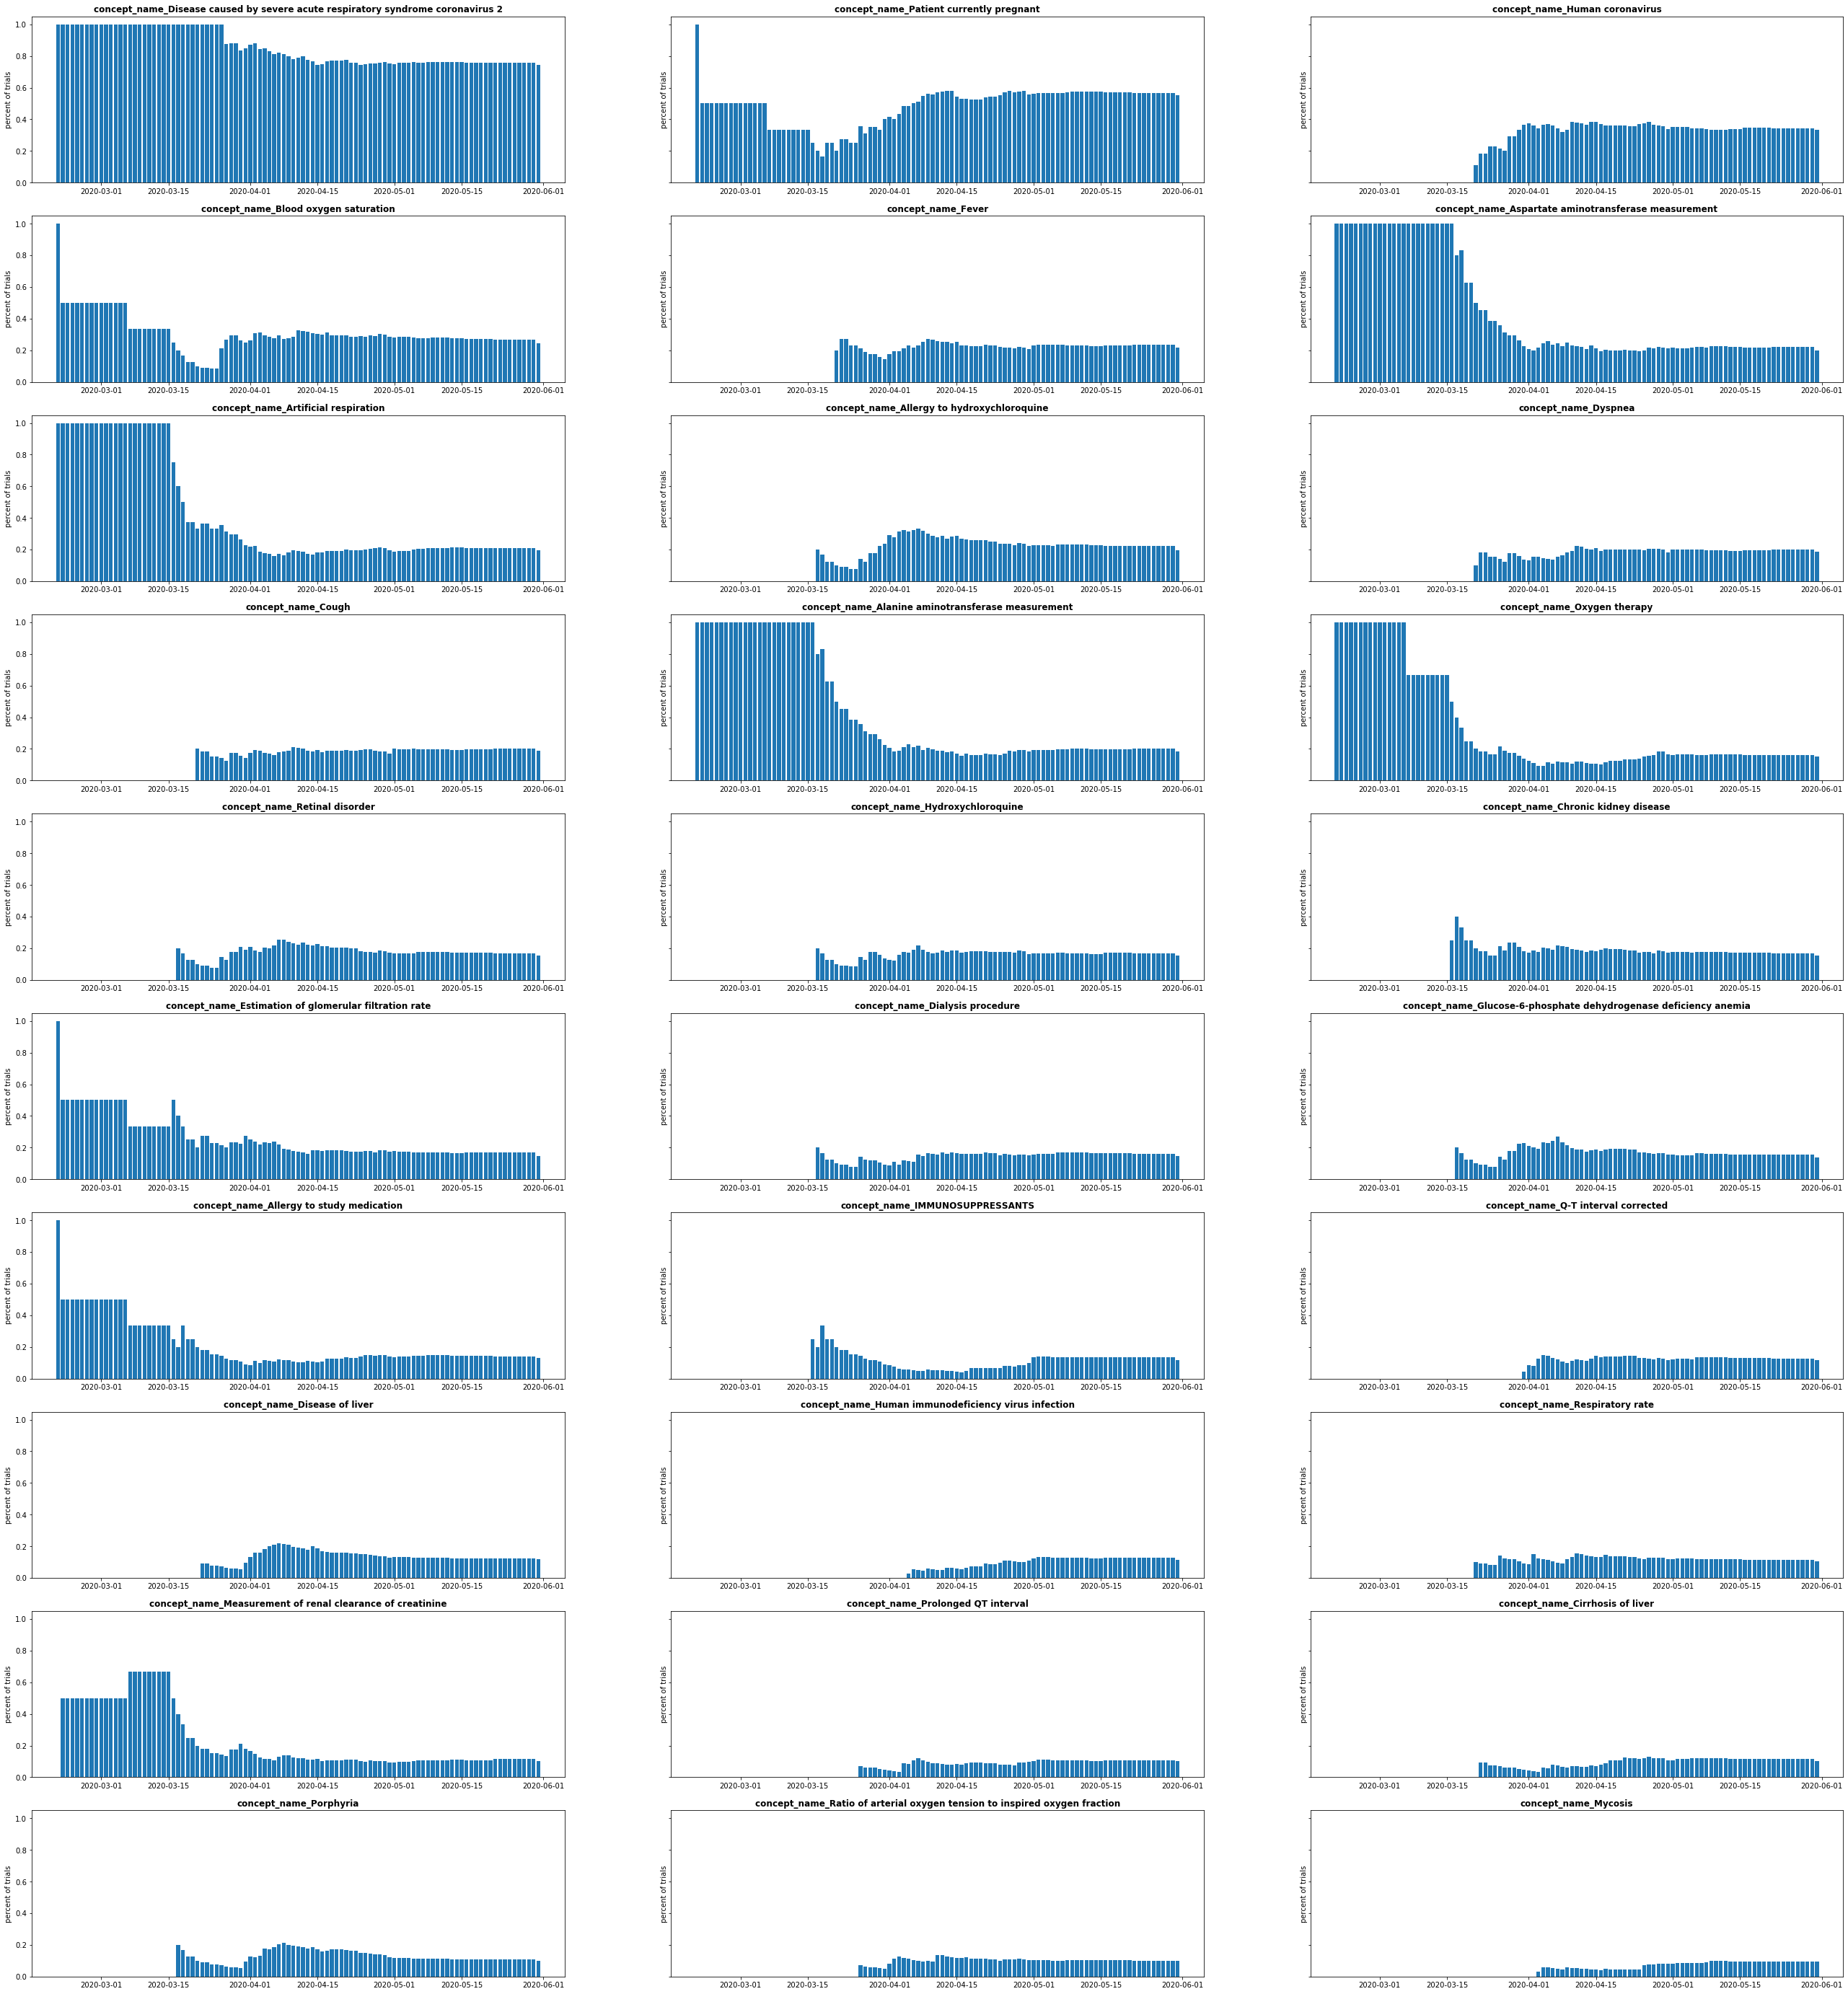

In [10]:
make_plot_grid(df)

In [20]:
### THIS WILL GENERATE THE WEEKLY DF OF NEW CASES ONLY

# shows what pct of nct_id's have criterion about concept_name x

df = get_weekly_aggregation(Y) \
        .reset_index() \
        .assign(start_week=lambda row: row.start_week.dt.strftime('%b %d')) \
        .set_index(keys=['start_week'])

df = df.mask(df > 1, 1)

df = df \
        .sort_values(by=df.last_valid_index(), axis=1, ascending=False) \
        .iloc[:, :30]

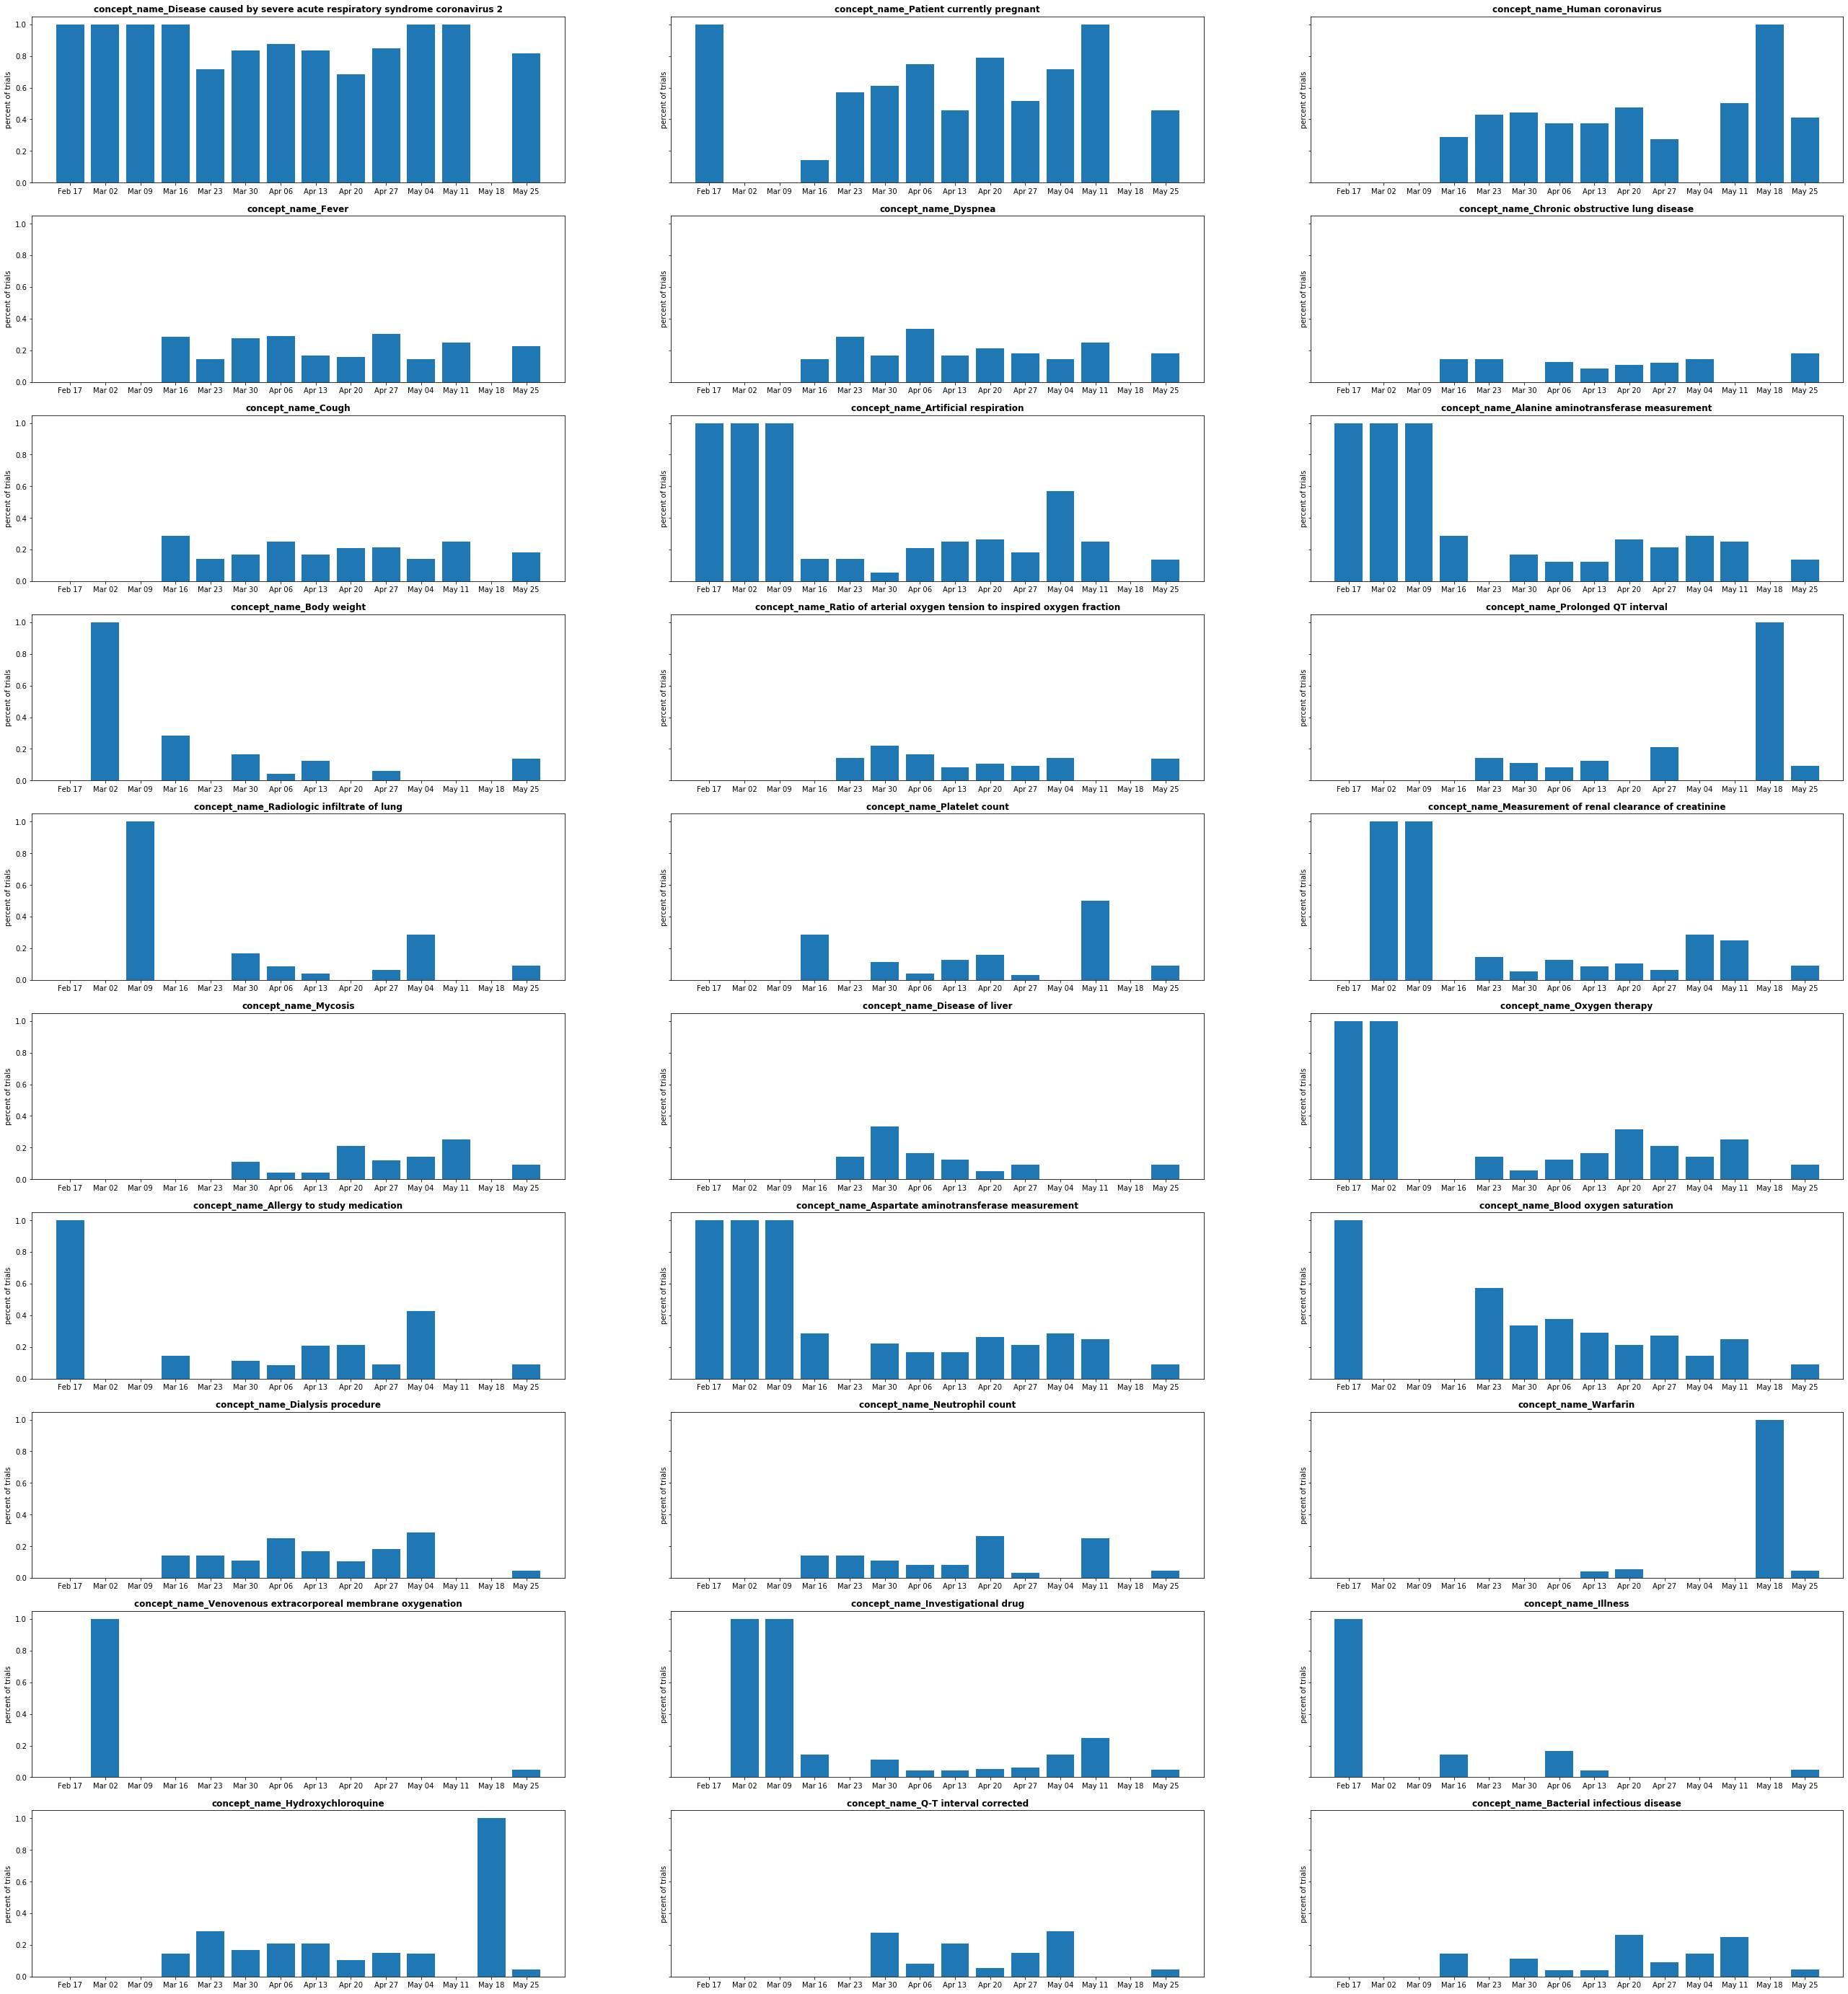

In [19]:
make_plot_grid(df)